# Traitement d'image : quelques essais simples

Je présente ici l'appel à un algorithme de détection de contours (Canny), implémenté dans OpenCV.
Je présente ensuite une suite de filtres simples appliqués à une image.

In [1]:
from utils.download import download_file
import cv2
from pathlib import Path
from matplotlib import pyplot as plt

In [2]:
# téléchargement d'une image exemple
img_path = download_file("https://upload.wikimedia.org/wikipedia/commons/6/63/Horse-racing-4.jpg")

image = cv2.imread(str(img_path))
# Image de base, au format "RGB"
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Dossier de sauvegarde des résultats
out_dir = Path("out")
out_dir.mkdir(parents=True,exist_ok=True)

### Décomposition en trois couleurs (Red, Green, Blue) de l'image

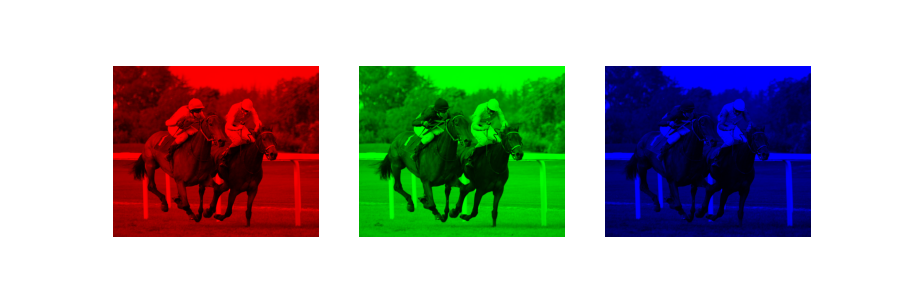

In [3]:
import numpy as np

plt.figure(figsize=(9,3))
for i, couleur in enumerate('RGB'):
    one_channel_image = np.zeros_like(image)
    one_channel_image[...,i] = image[...,i]
    cv2.imwrite(str(out_dir / (couleur + "_" + img_path.name)),one_channel_image)
    plt.subplot(1,3,i+1)
    plt.axis('off')
    plt.imshow(one_channel_image)

### Illustration d'une suite de filtres appliquées sur une image

Ici, je présente une détection de contours "simple", avec l'application uniquement de convolutions.

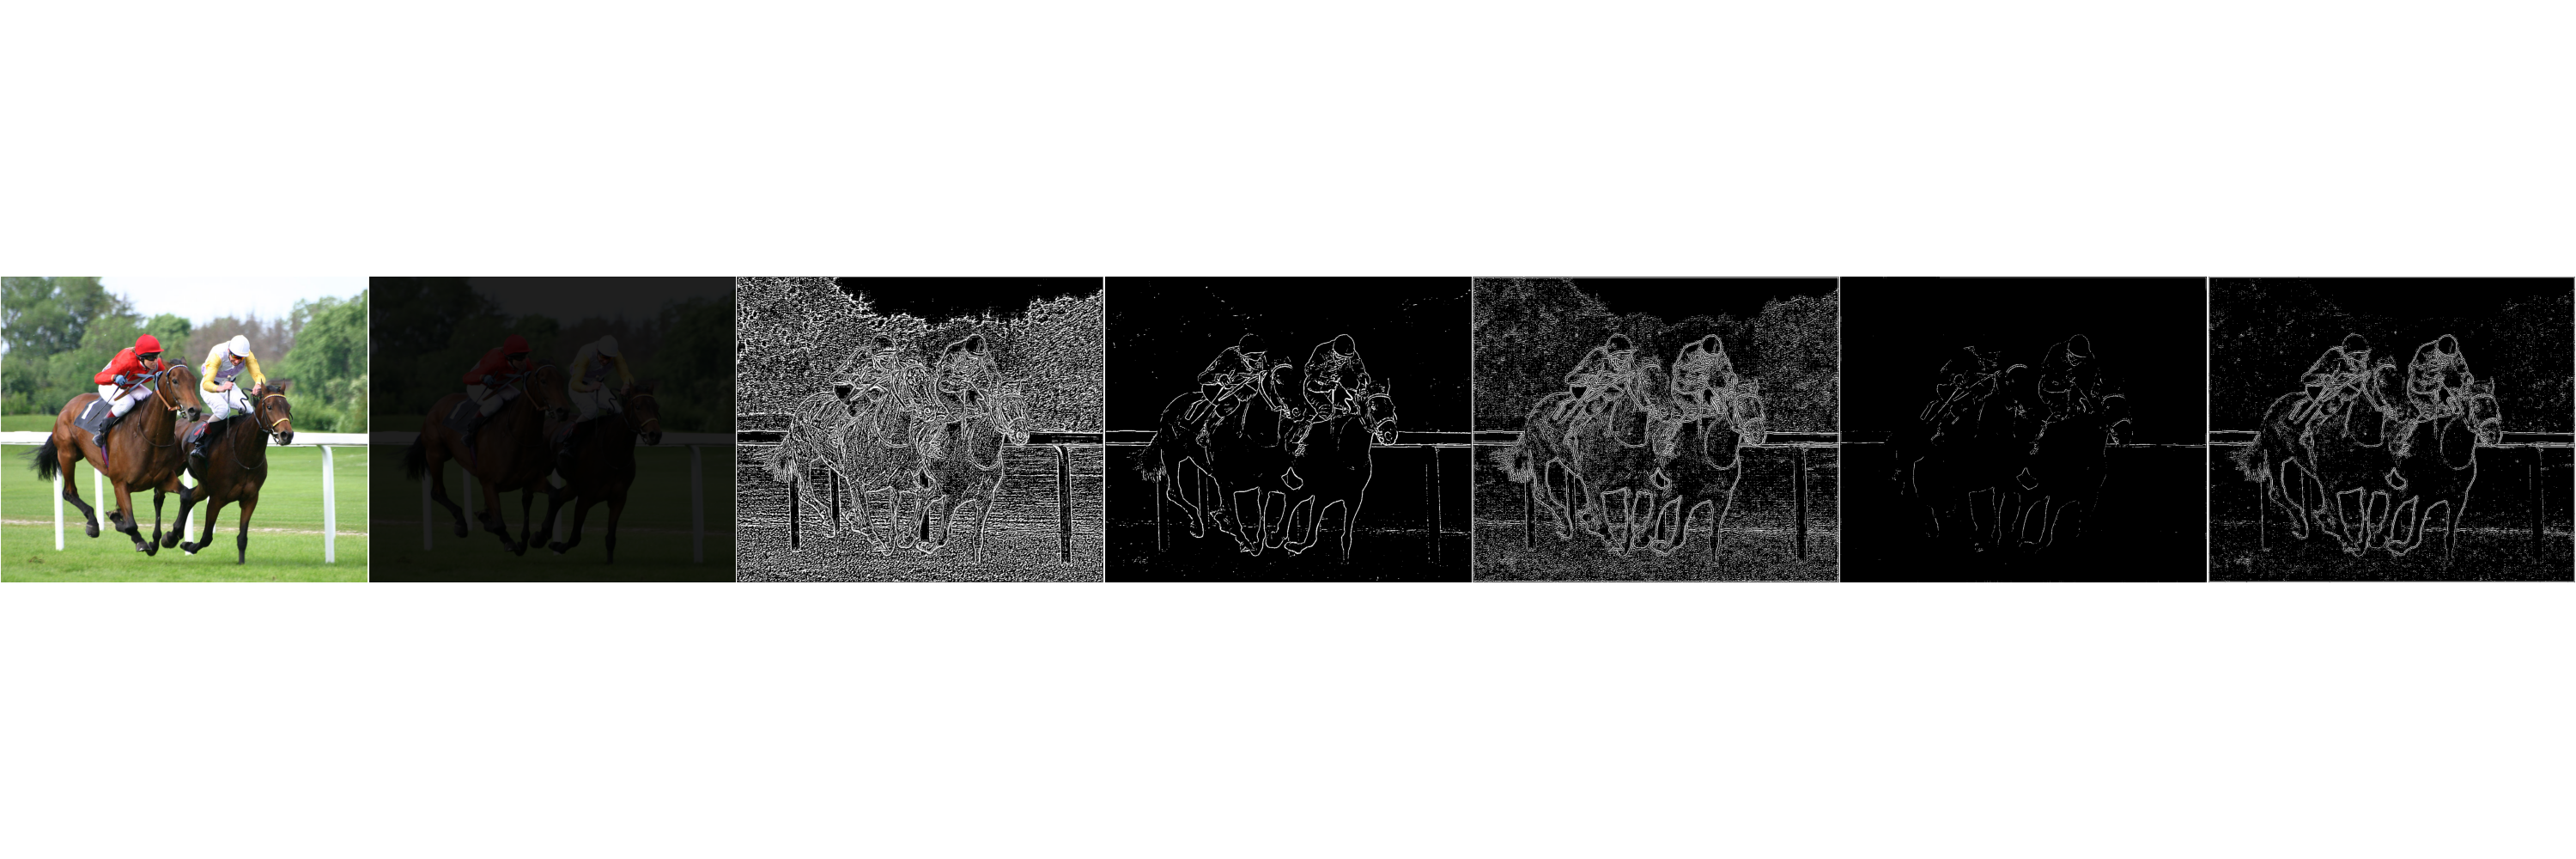

In [5]:
import torch

# initialisation des filtres
edge_kernel= torch.tensor(
    [
        [-1, -1,-1],
        [-1, 8,-1],
        [-1, -1,-1]
    ], dtype=torch.float64)
average_kernel = torch.tensor(
    [
        [1,2,4,2,1],
        [2,4,8,4,2],
        [4,8,16,8,4],
        [2,4,8,4,2],
        [1,2,4,2,1],
    ], dtype=torch.float64)/256

average_kernel = torch.tensor(
    [
        [1, 1,1],
        [1, 8,1],
        [1, 1,1]
    ], dtype=torch.float64)/128

# Conversion en tenseur de la matrice d'image
image_tensor = torch.tensor(image / 255)
# l'ordre des dimensions dans Pytorch requiert d'avoir les canaux avant les dimensions spatiales
image_tensor = image_tensor.permute([2,0,1]).unsqueeze(0)


nb_iter = 3
plt.figure(figsize=(10*nb_iter,10))
plt.subplot(1,2*nb_iter+1,1)
plt.imshow((image_tensor*255).squeeze(0).permute([1,2,0]).to(torch.uint8), cmap='grey')
plt.axis('off')
for i in range(nb_iter):
    nb_channels = image_tensor.shape[-3]
    image_tensor = torch.nn.functional.conv2d(
        image_tensor,
        average_kernel.expand(nb_channels,1,average_kernel.shape[-2],average_kernel.shape[-1]),
        stride=1,
        padding=1,
        groups=nb_channels
        )
    plt.subplot(1,2*nb_iter+1,2*i+2)
    plt.imshow((image_tensor*255).squeeze(0).permute([1,2,0]).to(torch.uint8), cmap='grey')
    plt.axis('off')
    image_tensor = torch.nn.functional.conv2d(
        image_tensor,
        edge_kernel.expand(1,nb_channels,edge_kernel.shape[-2],edge_kernel.shape[-1]),
        stride=1,
        padding=1,
        groups=1
        )
    plt.subplot(1,2*nb_iter+1,2*i+3)
    plt.imshow((image_tensor*255).squeeze(0).permute([1,2,0]).to(torch.uint8), cmap='grey')
    plt.axis('off')
plt.tight_layout( pad=0.1)
plt.savefig(str(out_dir / ("filters_" + img_path.name)))

### Détection de contours, avec l'algorithme de Canny (implémenté dans OpenCV)

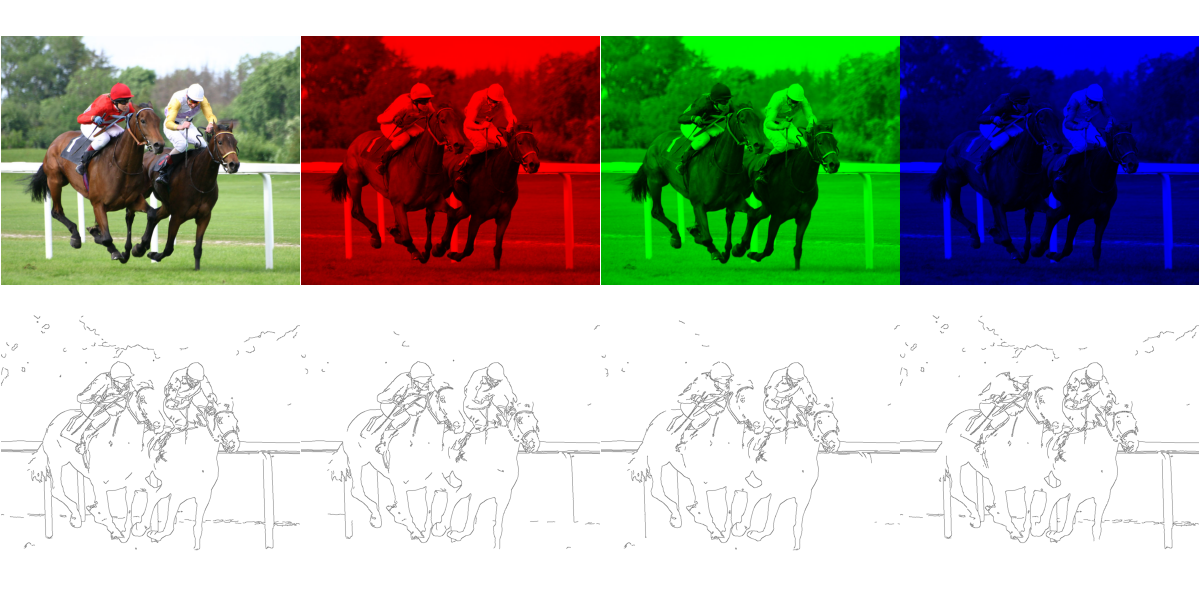

No such comm: cd81184fdb1b4ebfa2ccb08e92d8929b
No such comm: cd81184fdb1b4ebfa2ccb08e92d8929b
No such comm: cd81184fdb1b4ebfa2ccb08e92d8929b
No such comm: cd81184fdb1b4ebfa2ccb08e92d8929b
No such comm: cd81184fdb1b4ebfa2ccb08e92d8929b
No such comm: cd81184fdb1b4ebfa2ccb08e92d8929b


In [4]:
# On applique un bruit gaussien pour améliorer la détection des contours
img_blur = cv2.GaussianBlur(image,(3,3), sigmaX=0, sigmaY=0) 
# Appel à l'algorithme de détection des contours
edge_image = cv2.Canny(image=img_blur, threshold1=100, threshold2=200) 
edge_image = 255-edge_image # Pour inverser contour et fond

plt.close('all')
plt.figure(figsize=(12,6))

plt.subplot(2,4,1)
plt.axis('off')
plt.imshow(image)
plt.subplot(2,4,5)
plt.axis('off')
plt.imshow(edge_image, cmap='gray')


# Sauvegarde de l'image résultat dans un fichier
cv2.imwrite(str(out_dir / ("edges_" + img_path.name)),edge_image)


for i, couleur in enumerate('RGB'):
    # On conserve uniquement un canal de couleur
    one_channel_image = np.zeros_like(image)
    one_channel_image[...,i] = image[...,i]
    # On applique un bruit gaussien pour améliorer la détection des contours
    one_channel_img_blur = cv2.GaussianBlur(one_channel_image,(3,3), sigmaX=0, sigmaY=0) 
    # Appel à l'algorithme de détection des contours sur l'image monochrome
    one_channel_edge_image = cv2.Canny(image=one_channel_img_blur, threshold1=100, threshold2=200) 
    one_channel_edge_image = 255-one_channel_edge_image # Pour inverser contour et fond

    # Affichage de l'image monochrome
    cv2.imwrite(str(out_dir / (couleur + "_" + img_path.name)),one_channel_image)
    plt.subplot(2,4,i+2)
    plt.axis('off')
    plt.imshow(one_channel_image)
    # Affichage du contour calculé sur l'image monochrome
    cv2.imwrite(str(out_dir / (couleur + "_edges_" + img_path.name)),one_channel_edge_image)
    plt.subplot(2,4,i+6)
    plt.axis('off')
    plt.imshow(one_channel_edge_image, cmap='gray')

plt.tight_layout( pad=0.1)